In [2]:
import numpy as np
import sys
sys.path.append('../')
import os
import pickle
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import multiprocessing as mp
import subprocess
from tqdm import tqdm
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Layer, Conv2D, MaxPooling2D, Dense, Flatten, Input, Dropout, Conv2DTranspose, Reshape
from tensorflow.keras.backend import random_normal
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import categorical_crossentropy, mean_squared_error, KLD
from tensorflow.keras.metrics import categorical_accuracy
from tensorflow.keras.regularizers import L1
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
import tensorflow_probability as tfp

from models import *

## Load Data (FER+)

In [3]:
# Load data
data = np.load('../FER_plus.npz', allow_pickle=True)

# Training data
X_train = np.expand_dims(data['xtrain'], axis=-1).astype(np.float) * 1./255
Y_train = data['ytrain']

with open('../FER_plus_train_bb.pkl', 'rb') as fh:
    train_bb_dict = pickle.load(fh)

# List of indices with bounding box labels
train_bb_idxs = list(train_bb_dict.keys())
X_train_bb = X_train[train_bb_idxs]
Y_train_bb = Y_train[train_bb_idxs]
bb_train = np.zeros((len(train_bb_idxs),4))

for i, idx in enumerate(train_bb_idxs):
    bb_train[i] = train_bb_dict[idx]

print('Train (with BB): {}'.format(X_train_bb.shape[0]))

# Validation data
X_val = np.expand_dims(data['xvalid'], axis=-1).astype(np.float) * 1./255
Y_val = data['yvalid']

with open('../FER_plus_validation_bb.pkl', 'rb') as fh:
    val_bb_dict = pickle.load(fh)

# List of indices with bounding box labels
val_bb_idxs = list(val_bb_dict.keys())
X_val_bb = X_val[val_bb_idxs]
Y_val_bb = Y_val[val_bb_idxs]
bb_val = np.zeros((len(val_bb_idxs),4))

for i, idx in enumerate(val_bb_idxs):
    bb_val[i] = val_bb_dict[idx]

print('Validation (with BB): {}'.format(X_val_bb.shape[0]))

# Test data
X_test = np.expand_dims(data['xtest'], axis=-1).astype(np.float) * 1./255
Y_test = data['ytest']

with open('../FER_plus_test_bb.pkl', 'rb') as fh:
    test_bb_dict = pickle.load(fh)

# List of indices with bounding box labels
test_bb_idxs = list(test_bb_dict.keys())
X_test_bb = X_test[test_bb_idxs]
Y_test_bb = Y_test[test_bb_idxs]
bb_test = np.zeros((len(test_bb_idxs),4))

for i, idx in enumerate(test_bb_idxs):
    bb_test[i] = test_bb_dict[idx]

print('Test (with BB): {}'.format(X_test_bb.shape[0]))

labels = data['labels']

Train (with BB): 23408
Validation (with BB): 2911
Test (with BB): 2930


In [115]:
emotion_bb_vae = EmotionBBVAE(100, beta=3, linear=True, sparse=True)
emotion_bb_vae.summary()

Model: "EmotionBBVAE"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      [(None, 48, 48, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 48, 48, 16)   160         encoder_input[0][0]              
__________________________________________________________________________________________________
max_pooling2d_3 (MaxPooling2D)  (None, 24, 24, 16)   0           conv2d_3[0][0]                   
__________________________________________________________________________________________________
conv2d_4 (Conv2D)               (None, 24, 24, 32)   4640        max_pooling2d_3[0][0]            
_______________________________________________________________________________________

In [116]:
# Up to 100
history = emotion_bb_vae.fit(X_train_bb, [X_train_bb, Y_train_bb, bb_train], 
                             val_data=(X_val_bb, [X_val_bb, Y_val_bb, bb_val]), 
                             epochs=150, batch_size=32)

Epoch 1/150
732/732 [==============================] - 29s 39ms/step - loss: 84.9965 - reconDecoderVAE_loss: 37.8354 - emotionDecoderVAE_loss: 1.4374 - bbDecoderVAE_loss: 34.1397 - emotionDecoderVAE_categorical_accuracy: 0.3170 - val_loss: 45.5763 - val_reconDecoderVAE_loss: 20.9809 - val_emotionDecoderVAE_loss: 1.1735 - val_bbDecoderVAE_loss: 16.5703 - val_emotionDecoderVAE_categorical_accuracy: 0.3985
Epoch 2/150
732/732 [==============================] - 29s 39ms/step - loss: 38.6651 - reconDecoderVAE_loss: 18.1352 - emotionDecoderVAE_loss: 1.1076 - bbDecoderVAE_loss: 12.8819 - emotionDecoderVAE_categorical_accuracy: 0.4279 - val_loss: 35.6562 - val_reconDecoderVAE_loss: 16.1129 - val_emotionDecoderVAE_loss: 1.1062 - val_bbDecoderVAE_loss: 12.5439 - val_emotionDecoderVAE_categorical_accuracy: 0.4304
Epoch 3/150
732/732 [==============================] - 28s 38ms/step - loss: 32.8772 - reconDecoderVAE_loss: 15.2901 - emotionDecoderVAE_loss: 1.0574 - bbDecoderVAE_loss: 10.5988 - emoti

732/732 [==============================] - 29s 40ms/step - loss: 15.3191 - reconDecoderVAE_loss: 7.9643 - emotionDecoderVAE_loss: 0.6504 - bbDecoderVAE_loss: 2.4540 - emotionDecoderVAE_categorical_accuracy: 0.6707 - val_loss: 19.1785 - val_reconDecoderVAE_loss: 8.5142 - val_emotionDecoderVAE_loss: 0.7171 - val_bbDecoderVAE_loss: 5.6728 - val_emotionDecoderVAE_categorical_accuracy: 0.6355
Epoch 42/150
732/732 [==============================] - 31s 42ms/step - loss: 15.1710 - reconDecoderVAE_loss: 7.9173 - emotionDecoderVAE_loss: 0.6426 - bbDecoderVAE_loss: 2.3675 - emotionDecoderVAE_categorical_accuracy: 0.6756 - val_loss: 19.9540 - val_reconDecoderVAE_loss: 8.4799 - val_emotionDecoderVAE_loss: 0.7114 - val_bbDecoderVAE_loss: 6.5208 - val_emotionDecoderVAE_categorical_accuracy: 0.6414
Epoch 43/150
732/732 [==============================] - 32s 44ms/step - loss: 15.1615 - reconDecoderVAE_loss: 7.9021 - emotionDecoderVAE_loss: 0.6445 - bbDecoderVAE_loss: 2.3779 - emotionDecoderVAE_categor

732/732 [==============================] - 31s 42ms/step - loss: 13.8564 - reconDecoderVAE_loss: 7.3303 - emotionDecoderVAE_loss: 0.5746 - bbDecoderVAE_loss: 1.8471 - emotionDecoderVAE_categorical_accuracy: 0.7098 - val_loss: 18.1750 - val_reconDecoderVAE_loss: 8.0411 - val_emotionDecoderVAE_loss: 0.6838 - val_bbDecoderVAE_loss: 5.3619 - val_emotionDecoderVAE_categorical_accuracy: 0.6551
Epoch 82/150
732/732 [==============================] - 31s 43ms/step - loss: 13.8500 - reconDecoderVAE_loss: 7.3348 - emotionDecoderVAE_loss: 0.5753 - bbDecoderVAE_loss: 1.8374 - emotionDecoderVAE_categorical_accuracy: 0.7113 - val_loss: 18.1803 - val_reconDecoderVAE_loss: 8.0333 - val_emotionDecoderVAE_loss: 0.6835 - val_bbDecoderVAE_loss: 5.3522 - val_emotionDecoderVAE_categorical_accuracy: 0.6551
Epoch 83/150
732/732 [==============================] - 34s 47ms/step - loss: 13.8567 - reconDecoderVAE_loss: 7.3244 - emotionDecoderVAE_loss: 0.5738 - bbDecoderVAE_loss: 1.8551 - emotionDecoderVAE_categor

732/732 [==============================] - 31s 42ms/step - loss: 13.2681 - reconDecoderVAE_loss: 7.0984 - emotionDecoderVAE_loss: 0.5446 - bbDecoderVAE_loss: 1.5860 - emotionDecoderVAE_categorical_accuracy: 0.7286 - val_loss: 17.9872 - val_reconDecoderVAE_loss: 7.8881 - val_emotionDecoderVAE_loss: 0.6679 - val_bbDecoderVAE_loss: 5.3431 - val_emotionDecoderVAE_categorical_accuracy: 0.6654
Epoch 122/150
732/732 [==============================] - 31s 42ms/step - loss: 13.2410 - reconDecoderVAE_loss: 7.0896 - emotionDecoderVAE_loss: 0.5432 - bbDecoderVAE_loss: 1.5759 - emotionDecoderVAE_categorical_accuracy: 0.7268 - val_loss: 18.0311 - val_reconDecoderVAE_loss: 7.8778 - val_emotionDecoderVAE_loss: 0.6712 - val_bbDecoderVAE_loss: 5.3687 - val_emotionDecoderVAE_categorical_accuracy: 0.6548
Epoch 123/150
732/732 [==============================] - 30s 42ms/step - loss: 13.2545 - reconDecoderVAE_loss: 7.0888 - emotionDecoderVAE_loss: 0.5428 - bbDecoderVAE_loss: 1.5881 - emotionDecoderVAE_categ

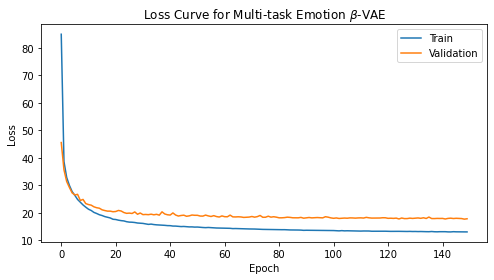

In [136]:
plt.figure(figsize=(8,4))
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title(r'Loss Curve for Multi-task Emotion $\beta$-VAE')
plt.legend()